# 🎵Music🎵 Generation using LSTM Networks

![Kaggle Logo](https://images.pexels.com/photos/164821/pexels-photo-164821.jpeg)

Music primarily consists of notes and chords, serving as fundamental elements in its composition. Music can be considered as a sequence of these notes and chords. Notes act as the building blocks, conveying both the pitch (or frequency) of the sound and its duration. For example, in “C4”, “C” represents the pitch of the sound and the number “4” represents its duration. On the other hand, chords are formed by playing multiple notes simultaneously. For example, the notation 'A4:G4' represents two notes, 'A4' and 'G4', played together. We can obtain these sequences of notes and chords from MIDI files. The task is how can we use these sequences of notes and chords to train the model and finally use it to generate music.

The classical music dataset contains the albums of various musicians. Every album comprises music stored as MIDI files. MIDI (Musical Instrument Digital Interface) serves as a technical specification outlining a communication protocol, digital interface, and electrical connectors. It facilitates the connection of diverse electronic musical instruments, computers, and associated audio devices for the purpose of playing, editing, and recording music. Whenever a musician interacts with a MIDI instrument, whether pressing keys, buttons, or adjusting knobs and sliders, these actions are translated into MIDI data. (source: [MIDI - Wikipedia](https://en.wikipedia.org/wiki/MIDI)).

To prepare the music data for training a model like a neural network, the first step involves extracting information from these MIDI files and transforming it into a suitable format. The Python library "Music21" proves invaluable for this task, offering a range of tools tailored for working with music data.

## Imports

In [1]:
import os
os.chdir('/kaggle/input')
!pip install music21 # install music21 module

# user defined modules
from utils1.music_utils import * # importing all the required modules and user functions
from utils1.mytfutils import * # contains tensorflow utils
from modelxarchitecture.modelxarchitecture import MyModel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.8/22.8 MB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.4/199.4 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 2.3 MB/s eta 0:00:00


2024-03-26 14:58:04.702712: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-26 14:58:04.702826: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-26 14:58:04.862721: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Defining the task

To effectively train a model like a neural network using music data extracted from MIDI files for music generation, we need to organize the data into a structured format. This involves defining input features and corresponding labels.

The whole process involves:

1. Data Preparation: Start by extracting music data from MIDI files. This data typically consists of sequences of notes and chords.

2. **Defining inputs and labels: We establish a fixed-length sequence of notes or chords to serve as the input features for each sample. For instance, we might choose a sequence length of 10 elements. The label for a given input sequence is determined as the note or chord immediately following the end of that sequence. This label represents what the model should predict.**

3. Training Set Creation: Generate numerous input-output pairs using the fixed-length sequences and their corresponding labels. These pairs constitute our training dataset.

4. Training the Model: Train the neural network using the training dataset. During training, the model learns to predict the subsequent musical element based on the preceding sequence.

5. Generation: Once the model is trained, it can be used to generate music sequences. To do this, we provide an initial input sequence (seed) to the model, and it predicts the next musical element based on its learned patterns. The predicted element is then added to the input sequence, and the process is repeated iteratively to generate a longer music sequence. By leveraging the knowledge acquired during training, the model can produce new music that follows the style and structure of the training data. This generated music can be further refined or adjusted based on artistic preferences or specific requirements.

By structuring the data in this manner and training the model accordingly, we enable it to effectively learn the patterns and relationships within the music sequences, thereby enabling it to generate coherent and meaningful music sequences.

## Data Preparation

#### Creating dataset from midi files

We can extract notes and chords from the MIDI files using the methods from Music21 library. I have created a class named CreateDataset which can be found in utils1.music_utils module. It contains all the methods to extract these notes and chords as strings and more.\
For example,\
'C4', 'D5', 'G3' represent notes\
'A4:G4', 'A4:F5', 'F5:E-5' represent chords

We utilize the make_mappings() method from the CreateDataset class to perform various tasks starting from parsing the MIDI files to mapping the extracted notes and chords with unique normalized numbers. The code cell below demonstrates how we can extract notes and chords from the Beethoven music album and create a dataset using the make_mappings() method.

##### **By replacing the directory path in the below cell for a different album, we can train the LSTM model with that music. This is the only change you need to make!**
In this Notebook, only beeth album is used.

In [2]:
# define args
dirpath = "classical-music-midi/beeth" # change the dirpath depending on the music album you want to train the model
length = 30 # length of the sequence
name = os.path.basename(dirpath)
in_kaggle = True

# process data
dataset = CreateDataset(dirpath, length=length, name=name, in_kaggle=in_kaggle)
dataset.make_mappings()

#### Parsed data representations

In [3]:
print(f"There are {len(dataset.notes_chords_list)} compositions in the {name} album.")
print(f"Length of sequence in first composition: {len(dataset.notes_chords_list[0])}")
print(f"Parsed data representations of first 30 elements: {dataset.notes_chords_list[0][:30]}")

There are 29 compositions in the beeth album.
Length of sequence in first composition: 1586
Parsed data representations of first 30 elements: ['D4', 'E-4', 'F4', 'A4:G4', 'F4', 'G4', 'A4', 'B-4', 'F4', 'A4:G4', 'F4', 'G4', 'A4', 'B-4', 'A4', 'B-4', 'C5', 'D5', 'E5', 'B-4:E5', 'A4:F5', 'F5:E-5', 'D5', 'E-5', 'F5', 'G5', 'C5', 'D5:C5', 'B4', 'C5']


When training a neural network, it's essential to provide both input data (features) and their corresponding labels. However, with music data, we encounter sequences instead. To address this, we must determine suitable features and labels. This concept aligns with the essence of music generation, where the objective is to predict the succeeding note or chord based on a given sequence.

To achieve this, we select sequences of notes or chords of a fixed length (e.g., 30) from the musical snippet as features. The label is then assigned to the note or chord immediately following the last element of the selected sequence. The dataset as features and labels can be accessed through dataset.features and dataset.labels. Example of a sample of (features, label) is shown below

In [4]:
dataset.features[0], dataset.labels[0] # After parsing

(array(['D4', 'E-4', 'F4', 'A4:G4', 'F4', 'G4', 'A4', 'B-4', 'F4', 'A4:G4',
        'F4', 'G4', 'A4', 'B-4', 'A4', 'B-4', 'C5', 'D5', 'E5', 'B-4:E5',
        'A4:F5', 'F5:E-5', 'D5', 'E-5', 'F5', 'G5', 'C5', 'D5:C5', 'B4',
        'C5'], dtype='<U29'),
 'D5')

As we cannot train a model with strings, we need to convert these strings into appropriate numbers. Therefore, I mapped these strings to values ranging from 0.01 to 1.01. Additionally, I one-hot encoded the labels for prediction. The same sample feature and label, as shown above, are converted as follows:

In [5]:
dataset.features_normalized[0], dataset.labels_encoded[0] # After mapping to normalized numbers and encoding labels

(array([0.44308879, 0.53592967, 0.7696762 , 0.06034151, 0.7696762 ,
        0.95738174, 0.04136858, 0.12687326, 0.7696762 , 0.06034151,
        0.7696762 , 0.95738174, 0.04136858, 0.12687326, 0.04136858,
        0.12687326, 0.38009866, 0.46813306, 0.63180622, 0.1402808 ,
        0.05932962, 0.8109107 , 0.46813306, 0.55996205, 0.79775613,
        0.97964331, 0.38009866, 0.47648115, 0.20554769, 0.38009866]),
 array([0., 0., 0., ..., 0., 0., 0.]))

## Creating train and generate sets

Train set is obviously for training\
Generate set is for generating new pieces of music. Each sample from the generate set can be used to create possibly a new piece of music.

In [6]:
test_size = 0.01
random_state = 42
x_train, x_gen, y_train, y_gen = train_test_split(dataset.features_normalized, dataset.labels_encoded, test_size=test_size, random_state=random_state)

In [7]:
num_features = 1
x_train = x_train.reshape((-1, dataset.length, num_features)) # just making it as an appropriate input to the model
np.save(f'/kaggle/working/{dataset.name}_{dataset.length}.npy', x_gen) # saving the gen data for further use 

## Building and training the model

### Model Architecture

In [8]:
@tf.keras.utils.register_keras_serializable()
class MyModel(tf.keras.Model):
    def __init__(self, input_shape_, input_units, output_units, **kwargs):
        """
            input_shape: A tuple length representing (time_steps, features)
            input_units: number of units in the first layer (lstm layer)
            output_units: number of units in the output layer
        """
        super(MyModel, self).__init__(**kwargs)
        self.input_shape_ = input_shape_
        self.input_units = input_units
        self.output_units = output_units

        # Layers
        self.lstm1 = tf.keras.layers.LSTM(self.input_units, input_shape=self.input_shape_, return_sequences=False)
        self.dense1 = tf.keras.layers.Dense(512)
        self.batchNorm1 = tf.keras.layers.BatchNormalization()
        self.dense2 = tf.keras.layers.Dense(448)
        self.batchNorm2 = tf.keras.layers.BatchNormalization()
        self.dense_output = tf.keras.layers.Dense(self.output_units, activation='softmax')

    def call(self, inputs, training=False):    
        x = self.lstm1(inputs)
        x = self.dense1(x)
        x = self.batchNorm1(x, training=training)
        x = self.dense2(x)
        x = self.batchNorm2(x, training=training)
        x = self.dense_output(x)
        return x

    def get_config(self):
        config = super(MyModel, self).get_config()
        config.update({
            "input_shape_":self.input_shape_,
            "input_units":self.input_units,
            "output_units":self.output_units
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

### Creating the model and training

In [9]:
def create_compile_model():
    scaling = 4
    model_args = {}
    model_args["input_shape_"] = x_train.shape[1:]
    model_args["input_units"] = len(dataset.mapping)//scaling
    model_args["output_units"] = y_train.shape[1]
    model = MyModel(**model_args)

    compile_args = {}
    compile_args["loss"] = 'categorical_crossentropy'
    compile_args["optimizer"] = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(**compile_args)
    return model

In [10]:
model = create_compile_model()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Model details

In [11]:
inputs = tf.keras.Input(shape=x_train.shape[1:])
outputs = model(inputs)
intermediary_outputs = []
for layer in model.layers:
    inputs = layer(inputs)
    intermediary_outputs.append(inputs)
new_model = tf.keras.Model(inputs=model.input, outputs=intermediary_outputs)
new_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 988)            │     3,912,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       506,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 448)            │       229,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 448)            │         1,792 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3916)           │     1,758,284 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,410,796 (24.46 MB)

 Trainable params: 6,408,876 (24.45 MB)

 Non-trainable params: 1,920 (7.50 KB)

### Training the model

In [12]:
# defining the callbacks
def create_callbacks():
    callbacks = [EarlyStopping(monitor="loss", min_delta=0.002, patience=10, verbose=1, mode="auto", baseline=None, restore_best_weights=True,),
                 ReduceLROnPlateau(monitor="loss", factor=0.1, patience=4, verbose=1, mode="auto", min_delta=0.01, cooldown=0, min_lr=1e-9)]
    return callbacks

In [13]:
num_epochs = 200 # number of epochs to train
batch_size = 96
callbacks = create_callbacks()
history = model.fit(x_train, y_train, batch_size=batch_size,epochs=num_epochs, callbacks=callbacks, verbose=1)

Epoch 1/200
830/830 ━━━━━━━━━━━━━━━━━━━━ 29s 29ms/step - loss: 6.7269 - learning_rate: 0.0010
Epoch 2/200
830/830 ━━━━━━━━━━━━━━━━━━━━ 25s 30ms/step - loss: 5.4709 - learning_rate: 0.0010
Epoch 3/200
830/830 ━━━━━━━━━━━━━━━━━━━━ 25s 30ms/step - loss: 5.3720 - learning_rate: 0.0010
Epoch 4/200
830/830 ━━━━━━━━━━━━━━━━━━━━ 26s 32ms/step - loss: 5.3016 - learning_rate: 0.0010
Epoch 5/200
830/830 ━━━━━━━━━━━━━━━━━━━━ 28s 33ms/step - loss: 5.2704 - learning_rate: 0.0010
Epoch 6/200
830/830 ━━━━━━━━━━━━━━━━━━━━ 27s 32ms/step - loss: 5.2497 - learning_rate: 0.0010
Epoch 7/200
830/830 ━━━━━━━━━━━━━━━━━━━━ 27s 32ms/step - loss: 5.2336 - learning_rate: 0.0010
Epoch 8/200
830/830 ━━━━━━━━━━━━━━━━━━━━ 27s 33ms/step - loss: 5.2257 - learning_rate: 0.0010
Epoch 9/200
830/830 ━━━━━━━━━━━━━━━━━━━━ 27s 33ms/step - loss: 5.1927 - learning_rate: 0.0010
Epoch 10/200
830/830 ━━━━━━━━━━━━━━━━━━━━ 27s 32ms/step - loss: 5.1924 - learning_rate: 0.0010
Epoch 11/200
830/830 ━━━━━━━━━━━━━━━━━━━━ 27s 32ms/step - l

### Saving the model

In [14]:
path_to_save = '/kaggle/working/'
filename = dataset.name+f"_{dataset.length}"
save_model_as_json_h5(path_to_save, filename, model)

### Train Plot

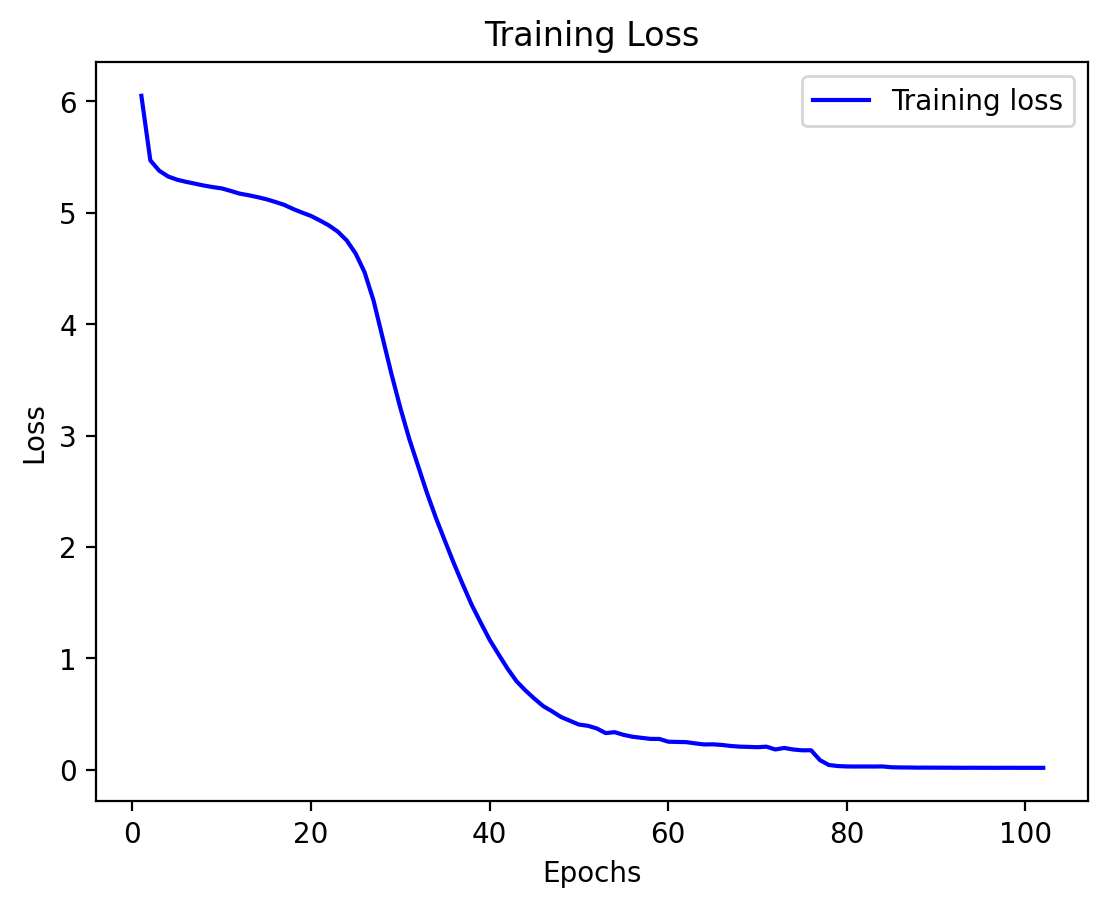

<Figure size 640x480 with 0 Axes>

In [15]:
def make_train_plot():
    train_loss = history.history['loss']
    epochs = range(1, len(train_loss) + 1)
    plt.plot(epochs, train_loss, 'b', label='Training loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    plt.savefig(path_to_save+f'/{name}_{dataset.length}.png')
make_train_plot()

## Generate Music using the trained model

We can generate the music using the Generator class from the utils1.music_utils module (user-defined) using x_gen (samples kept aside for generation), the dataset which also contains necessary mappings that are required for converting the encoded values back to notes and chords.

In [16]:
# creating generator object
generator = Generator(model, x_gen, dataset)

## Creating a playlist of music

With the code below, you can create a playlist of compositions. Adjust the note_count to determine the duration of the music. Additionally, modify the num_songs to specify the number of compositions you want to create.

In [17]:
count = 0
note_count = 200
num_songs = 10
generator.create_playlist(num_songs, note_count, direc_name = path_to_save+f"/music{count}", zip_file=True)
count+=1

### Checkout the music! Let me know in the comments.
### Also, download the model (both .json and .h5 file) and the generate set file to further be able to generate music without training again.
## Checkout furthermore for utility at [GitHub](https://github.com/Praneeth74/Music-Generation-using-LSTMs)